In [12]:
%run preamble_scripts.py

In [305]:
n_sim, nobs, expo = 100, 2000, 250
err_pnl, popSize_screening, popsize_capi = 3e5, 1000, 5000

In [308]:
# Setting the true model
f1, f2 = bs.loss_model("Weibull", ["r1", "m1"]), bs.loss_model("Lomax", ["α2", "σ2"])
f_true = bs.spliced_loss_model(f1, f2, "continuous")
parms_true = np.array([1/2, 1, 2.5, 3, 1.5])

f_true.set_ppf(), f_true.set_pdf(),f_true.set_cdf()

# We set the priority to the 90% quantile and the limit to the 0.99% quantile
P, L = f_true.ppf(parms_true, 0.9), f_true.ppf(parms_true, 0.99)
premiums = f_true.PP(parms_true), f_true.XOLP(parms_true, P, L)

%time PnLs = np.array(f_true.PnL(parms_true, P, L, expo, premiums, safety_loadings = [0.05, 0.05],  n_sim = err_pnl))
true_VaRs = [f_true.ppf(parms_true, prob) for prob in [0.95, 0.99, 0.995]]
true_cap = np.quantile(PnLs, [0.005, 0.01, 0.05])
true_cap

Wall time: 28.2 s


array([-173.97286783, -128.56898056,  -54.76639509])

In [321]:
# X = f_true.sample(parms_true, nobs)
model = "Weibull_Inverse-Weibull_continuous"
f, prior = f_spliced_dic[model], prior_dic[model]

trace, log_marg, DIC, WAIC = bs.smc(X, f, popsize_capi, prior)
Wass_dist = bs.compute_Wasserstein(X, f, trace.mean().values, 1)

Sample generation 0 from the gamma-gamma-gamma-gamma-gamma prior distribution
Generation: 1 ;temperature: 0.0006952285766601562 ;ESS: 2500 ;steps:3 ;particle moved: 99.88%
Generation: 2 ;temperature: 0.002938444198207435 ;ESS: 2499 ;steps:3 ;particle moved: 99.98%
Generation: 3 ;temperature: 0.009035849222640035 ;ESS: 2500 ;steps:3 ;particle moved: 99.9%
Generation: 4 ;temperature: 0.024462092282743125 ;ESS: 2499 ;steps:3 ;particle moved: 99.96000000000001%
Generation: 5 ;temperature: 0.05878799036705419 ;ESS: 2499 ;steps:3 ;particle moved: 99.83999999999999%
Generation: 6 ;temperature: 0.12547957213225008 ;ESS: 2499 ;steps:3 ;particle moved: 99.68%
Generation: 7 ;temperature: 0.24325295531872515 ;ESS: 2499 ;steps:3 ;particle moved: 99.78%
Generation: 8 ;temperature: 0.45340314369144985 ;ESS: 2500 ;steps:3 ;particle moved: 99.82%
Generation: 9 ;temperature: 0.8560282754408457 ;ESS: 2500 ;steps:3 ;particle moved: 99.88%
Generation: 10 ;temperature: 1.0 ;ESS: 4718 ;steps:3 ;particle move

(array([0.50172644, 0.74913088, 1.93025716, 1.77123284, 5.18047587]),
 array([0.5, 1. , 2.5, 3. , 1.5]))

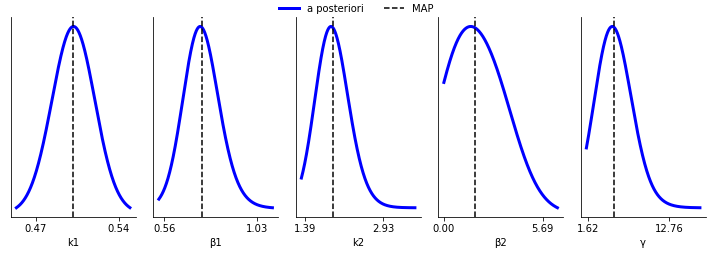

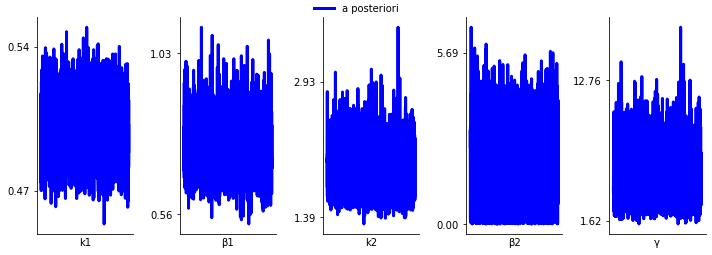

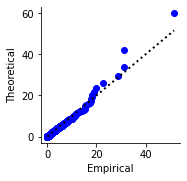

In [322]:
bs.posterior_plots(f, trace)
bs.trace_plots(f, trace)
bs.qq_plot(X, f, trace.mean().values)
trace.mean().values, parms_true

In [323]:
%time PnLs = np.array(f.PnL(trace.mean().values, P, L, expo, premiums, safety_loadings = [0.05, 0.05],  n_sim = 3e5))

Wall time: 31.2 s


In [324]:
def compute_pnl_post(trace):
    PNLS_post = []
    for i in range(int(err_pnl)):
        PNLS_post.append( f.PnL(trace.sample().values[0], P, L, 
                                expo, premiums, n_sim = 1)[0])
    return(np.quantile(PNLS_post, [0.005, 0.01, 0.05]))
%time PNLS_post = compute_pnl_post(trace)

Wall time: 1min 53s


In [325]:
np.quantile(PnLs, [0.005, 0.01, 0.05]), PNLS_post, true_cap

(array([-300.30360262, -203.51283586,  -72.88782478]),
 array([-424.75149525, -282.93463235, -100.16977329]),
 array([-173.97286783, -128.56898056,  -54.76639509]))

In [326]:
log_marg

-1505.2424920444082